In [214]:
import pickle
import requests
import networkx as nx
import json
from collections import defaultdict
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
import math

## Part 2:

### Write about genres and modularity
So far we have investigated how each rock artist is connected to each other through references on their wiki page. Each of these rock artists are associated with sub-genres based on the info box on their wiki page. Artists who shares a sub-genre likely have the same inspirations, or maybe they have colloborations. Therefore, a hypothesis can be made here, that artists that are characterized by the same sub-genre is more likely to be linked together compared to other artists.

### Testing the hypothesis with modularity

One way to test this hypothesis could be to use modularity. If each collection of artists within a certain sub-genre is considered as a community, then modularity could be used to show the interconnectivity between genres. Modularity is the measure of the quality of the partition between communitites. A high modularity indicates that the amount edges going between communities is very low. Therefore, a high modularity would suggest that artists are more densely connected within their sub-genres than between different sub-genres, supporting our hypothesis.


## Detecting the communities and calculating the modularity

With this information we will now create a network that are associated a genre and detect the communities. 

In [193]:
# Load rock artists network
url = 'https://raw.githubusercontent.com/LucasJuel/socialgraphs2025/main/assignments/Assignment%202/rock_artists_network.pkl'
response = requests.get(url)

G_rock = pickle.loads(response.content)

url2 = 'https://raw.githubusercontent.com/LucasJuel/socialgraphs2025/main/assignments/Assignment%202/artist_genres_without_rock.json'
response2 = requests.get(url2)
artist_genres = response2.json()

"""
Create a new network with only nodes that have genres,
and assign primary genre as node attribute
"""
# Create new graph but force it to be undirected

G_rock = G_rock.to_undirected()

G_filtered = nx.Graph()

# Map nodes to their primary genre
node_to_primary_genre = {}

for node in G_rock.nodes():
    # Check if node has genres (handle various naming formats)
    node_name = str(node)
    
    # Try different variations of the node name
    base_variations = [
        node_name,
        node_name.replace('_', ' '),
        node_name.replace(' ', '_'),
        node_name.replace('(band)', '').strip(),

    ]
    
    genres = None
    for variant in base_variations:
        if variant in artist_genres and artist_genres[variant]:
            genres = artist_genres[variant]
            break
        

    if genres:
        # Use first genre as primary genre
        primary_genre = genres[0]
        node_to_primary_genre[node] = primary_genre
        G_filtered.add_node(node, genre=primary_genre, all_genres=genres)
 #  else: 
       # print(f"Node: {node}, Genres: {genres}, Variant used: {variant}")

# Add edges between nodes that both have genres
for u, v in G_rock.edges():
    if u in node_to_primary_genre and v in node_to_primary_genre:
        # Copy edge attributes if they exist
        edge_data = G_rock.get_edge_data(u, v)
        if edge_data:
            G_filtered.add_edge(u, v, **edge_data)
        else:
            G_filtered.add_edge(u, v)


genre_to_nodes = defaultdict(list)

for node, genre in node_to_primary_genre.items():
    genre_to_nodes[genre].append(node)

# Convert to list of communities (sets)
communities = [set(nodes) for nodes in genre_to_nodes.values()]


"""
Main analysis function
"""

print(f"Original network: {G_rock.number_of_nodes()} nodes, {G_rock.number_of_edges()} edges")

print(f"Filtered network: {G_filtered.number_of_nodes()} nodes, {G_filtered.number_of_edges()} edges")
print(f"Removed {G_rock.number_of_nodes() - G_filtered.number_of_nodes()} nodes without genres")

# Print community statistics
print(f"\nFound {len(communities)} genre communities:")
for genre, nodes in sorted(genre_to_nodes.items(), key=lambda x: len(x[1]), reverse=True):
    print(f"  {genre}: {len(nodes)} nodes")

# Additional analysis
print("\nAdditional statistics:")

# Average degree by genre
print("\nAverage degree by genre:")
for genre, nodes in sorted(genre_to_nodes.items(), key=lambda x: len(x[1]), reverse=True)[:10]:
    degrees = [G_filtered.degree(node) for node in nodes if node in G_filtered]
    if degrees:
        avg_degree = np.mean(degrees)
        print(f"  {genre}: {avg_degree:.2f}")

# Inter-genre connectivity
#print("\nInter-genre edge statistics:")
#intra_genre_edges = 0
#inter_genre_edges = 0

#for u, v in G_filtered.edges():
    #if node_to_primary_genre[u] == node_to_primary_genre[v]:
        #intra_genre_edges += 1
    #else:
        #inter_genre_edges += 1

#total_edges = G_filtered.number_of_edges()
#print(f"  Intra-genre edges: {intra_genre_edges} ({100*intra_genre_edges/total_edges:.1f}%)")
#print(f"  Inter-genre edges: {inter_genre_edges} ({100*inter_genre_edges/total_edges:.1f}%)")


with open("filtered_rock_artists_network.pkl", 'wb') as f:
    pickle.dump(G_filtered, f)



Original network: 484 nodes, 5943 edges
Filtered network: 448 nodes, 5170 edges
Removed 36 nodes without genres

Found 91 genre communities:
  alternative rock: 64 nodes
  hard rock: 50 nodes
  pop rock: 25 nodes
  pop music: 21 nodes
  progressive rock: 16 nodes
  rock and roll: 15 nodes
  heavy metal music: 14 nodes
  new wave music: 13 nodes
  indie rock: 12 nodes
  blues rock: 10 nodes
  folk rock: 10 nodes
  post-grunge: 10 nodes
  punk rock: 9 nodes
  alternative metal: 9 nodes
  soft rock: 9 nodes
  pop-punk: 8 nodes
  art rock: 7 nodes
  arena rock: 7 nodes
  southern rock: 6 nodes
  nu metal: 5 nodes
  heartland rock: 5 nodes
  blues: 4 nodes
  groove metal: 4 nodes
  industrial rock: 4 nodes
  psychedelic rock: 4 nodes
  jazz rock: 3 nodes
  beat music: 3 nodes
  grunge: 3 nodes
  glam rock: 3 nodes
  funk: 3 nodes
  hip-hop: 3 nodes
  glam metal: 3 nodes
  post-punk: 3 nodes
  country music: 3 nodes
  country rock: 3 nodes
  indie pop: 3 nodes
  roots rock: 3 nodes
  instrum

The script detected 91 communities, each representing a unique sub-genre. Next the modularity of the communities can be found.

In [194]:
# NetworkX expects communities as list of sets
modularity = nx.community.modularity(G_filtered, communities)

total_edges = G_filtered.number_of_edges()

modularity_calculation = 0.0

for community in communities:
    # Calculate Lc: number of edges WITHIN this community
    Lc = 0
    for node1 in community:
        for node2 in community:
            if G_filtered.has_edge(node1, node2):
                Lc += 1
    Lc = Lc / 2  # Each edge was counted twice
    # Calculate kc: sum of degrees of nodes in community

    kc = sum(G_filtered.degree(node) for node in community)

    modularity_calculation += (Lc/total_edges - (kc/(2*total_edges)) ** 2)



print(f"Modularity of genre-based communities: {modularity:.4f}")
print(f"Modularity calculation check (not normalized): {modularity_calculation:.4f}")


Modularity of genre-based communities: 0.0885
Modularity calculation check (not normalized): 0.0885


In [195]:
with open('artist_genres_without_rock.json', 'r', encoding='utf-8') as f:
    artist_genres = json.load(f)

# Calculate total number of genres across all artists
total_genres = sum(len(genres) for genres in artist_genres.values())

# Calculate average
num_artists = len(artist_genres)
average_genres = total_genres / num_artists

print(f"Average genres per artist: {average_genres:.2f}")

Average genres per artist: 4.34


In [196]:
# Get unique genres
genres = list(set(nx.get_node_attributes(G_filtered, 'genre').values()))
genres.sort()

# Create edge count matrix
edge_counts = Counter()
for u, v in G_filtered.edges():
    genre_u = G_filtered.nodes[u]['genre']
    genre_v = G_filtered.nodes[v]['genre']
    # Order genres alphabetically for consistent counting
    edge_key = tuple(sorted([genre_u, genre_v]))
    edge_counts[edge_key] += 1

# Print top genre connections
print("\nTop 15 genre connections:")
for (g1, g2), count in edge_counts.most_common(15):
    if g1 == g2:
        print(f"  {g1} (internal): {count} edges")
    else:
        print(f"  {g1} <-> {g2}: {count} edges")


Top 15 genre connections:
  hard rock (internal): 191 edges
  alternative rock (internal): 182 edges
  hard rock <-> heavy metal music: 116 edges
  alternative rock <-> hard rock: 109 edges
  hard rock <-> progressive rock: 61 edges
  alternative rock <-> pop music: 57 edges
  hard rock <-> pop music: 56 edges
  heavy metal music (internal): 55 edges
  pop music <-> rock and roll: 54 edges
  alternative rock <-> pop rock: 54 edges
  hard rock <-> post-grunge: 53 edges
  alternative rock <-> punk rock: 51 edges
  pop music (internal): 50 edges
  pop music <-> pop rock: 48 edges
  alternative metal <-> alternative rock: 48 edges


### Detect the communities, discuss the value of modularity in comparison to the genres.

It was possible to detect genres for 448 nodes. The modularity was calculated using formula 8.12 in the book and also confirmed using the NetworkX built in function. 

In the initial data processing, it could be seen that, "rock" and "rock music" was the primary genre for most nodes. This network had a very low modularity of 0.0956 and thus the communities was quite interconnected. However it could be argued that "rock" and "rock music" is really the umbrella term for all sub genres. Therefore a new graph was calculated excluding these. Which resulted in a even lower modularity of 0.0885. This suggests a very weak community structure, and indicates that nodes within the same genre are only slightly more likely to be connected, than being connected to random nodes. This does not support the proposed hypothesis. 

The low modularity could be explained by high cross genre influence, or simply be due to the fact that sub-genres are not that distint from each other. With an average of 4.34 sub-genres per artists, it suggests that many artists cross between different sub-genres, and therefore do not belong in a specific sub-genre community. Since the sub-genre that was picked as the main genre for each artist, was simply the first sub-genre in the list, it was more or less random which genre was considered the primary one. Therefore it makes sense that the modularity is low, since every node could arguably belong to a different community. 

### Calculating the D matrix

In this sub assignment, the D matrix is constructed using only the 7 most common genres and the 7 most common communities (excluding "rock" and "rock music"). When making the original "artist_genres_without_rock.json", the following genres was found to be most common.

- alternative rock: 135 artists 
- hard rock: 132 artists
- pop rock: 105 artists
- alternative metal: 53 artists
- blues rock: 50 artists
- pop: 50 artists
- heavy metal music: 50 artists
- pop music: 49 artists
- heavy metal: 48 artists


In [197]:
"""
Calculate the degree matrix D (diagonal matrix with node degrees)
"""

n = 7
node_list = list(G_filtered.nodes())
D = np.zeros((n, n))

most_common_genre = ["alternative rock", "hard rock", "pop rock", "alternative metal", "blues rock", "pop", "heavy metal music"]


# Get top n genres by community size
top_communities = []
for genre, nodes in sorted(genre_to_nodes.items(), key=lambda x: len(x[1]), reverse=True)[:n]:
    top_communities.append(genre)


for i, genre1 in enumerate(most_common_genre):
    if genre1 not in genre_to_nodes:
        print(f"Warning: '{genre1}' not found in data, skipping...")
        continue
        
    nodes1 = genre_to_nodes[genre1]
    
    for j, genre2 in enumerate(top_communities):
        nodes2 = genre_to_nodes[genre2]
        
        # Count edges between nodes of these two genres
        edge_count = 0
        for node1 in nodes1:
            for node2 in nodes2:
                if G_filtered.has_edge(node1, node2):
                    edge_count += 1
        
        # If same genre, divide by 2 (each edge counted twice)
        if genre1 == genre2:
            edge_count = edge_count // 2
            
        D[i, j] = edge_count
    

# Print with nice formatting
print("\nGenre Connectivity Matrix:")
print("="*50)

# Print as DataFrame for better readability
import pandas as pd
df = pd.DataFrame(D, index=most_common_genre, columns=top_communities)
df = df.astype(int)  # Convert to integers for cleaner display
print(df)

# Print some statistics
print("\n" + "="*50)
print("Matrix Statistics:")
print(f"Total edges in matrix: {int(np.sum(D))}")
print(f"Diagonal sum (within-genre edges): {int(np.sum(np.diag(D)))}")
print(f"Off-diagonal sum (between-genre edges): {int(np.sum(D) - np.sum(np.diag(D)))}")
print("Percentage of within-genre edges: ", 100 * np.sum(np.diag(D)) / np.sum(D))




Genre Connectivity Matrix:
                   alternative rock  hard rock  pop rock  pop music  \
alternative rock                182        109        54         57   
hard rock                       109        191        37         56   
pop rock                         54         37        11         48   
alternative metal                48         34         3          5   
blues rock                        7         13         2          3   
pop                               1          6         5          6   
heavy metal music                26        116        10         12   

                   progressive rock  rock and roll  heavy metal music  
alternative rock                 40             12                 26  
hard rock                        61             27                116  
pop rock                         17             12                 10  
alternative metal                14              2                 25  
blues rock                        3        

### Analysis of the D-matrix
From the D-matrix it can be observed that majority of edges are between genre edges, with only 26.4% of edges being within genre. This further weakens the hypothesis, since the majority of edges goes accross genres. It is inline with the low modularity that was found, since with high modularity within-community edges should be higher than between community edges. This all suggests that nodes are highly interconnected. 

It is also interesting that a genre like pop, which was found in 50 artists, have nearly no connections to any of the communities. Likewise, blues rock have very few connections. That suggests, even though these genres are not well represented in the communities even though they were found in a lot of artists. Indicating that the communities is not a good representation of the distribution of genres. 


### Plotting the communities

The top communities are plotted to show their grouping.

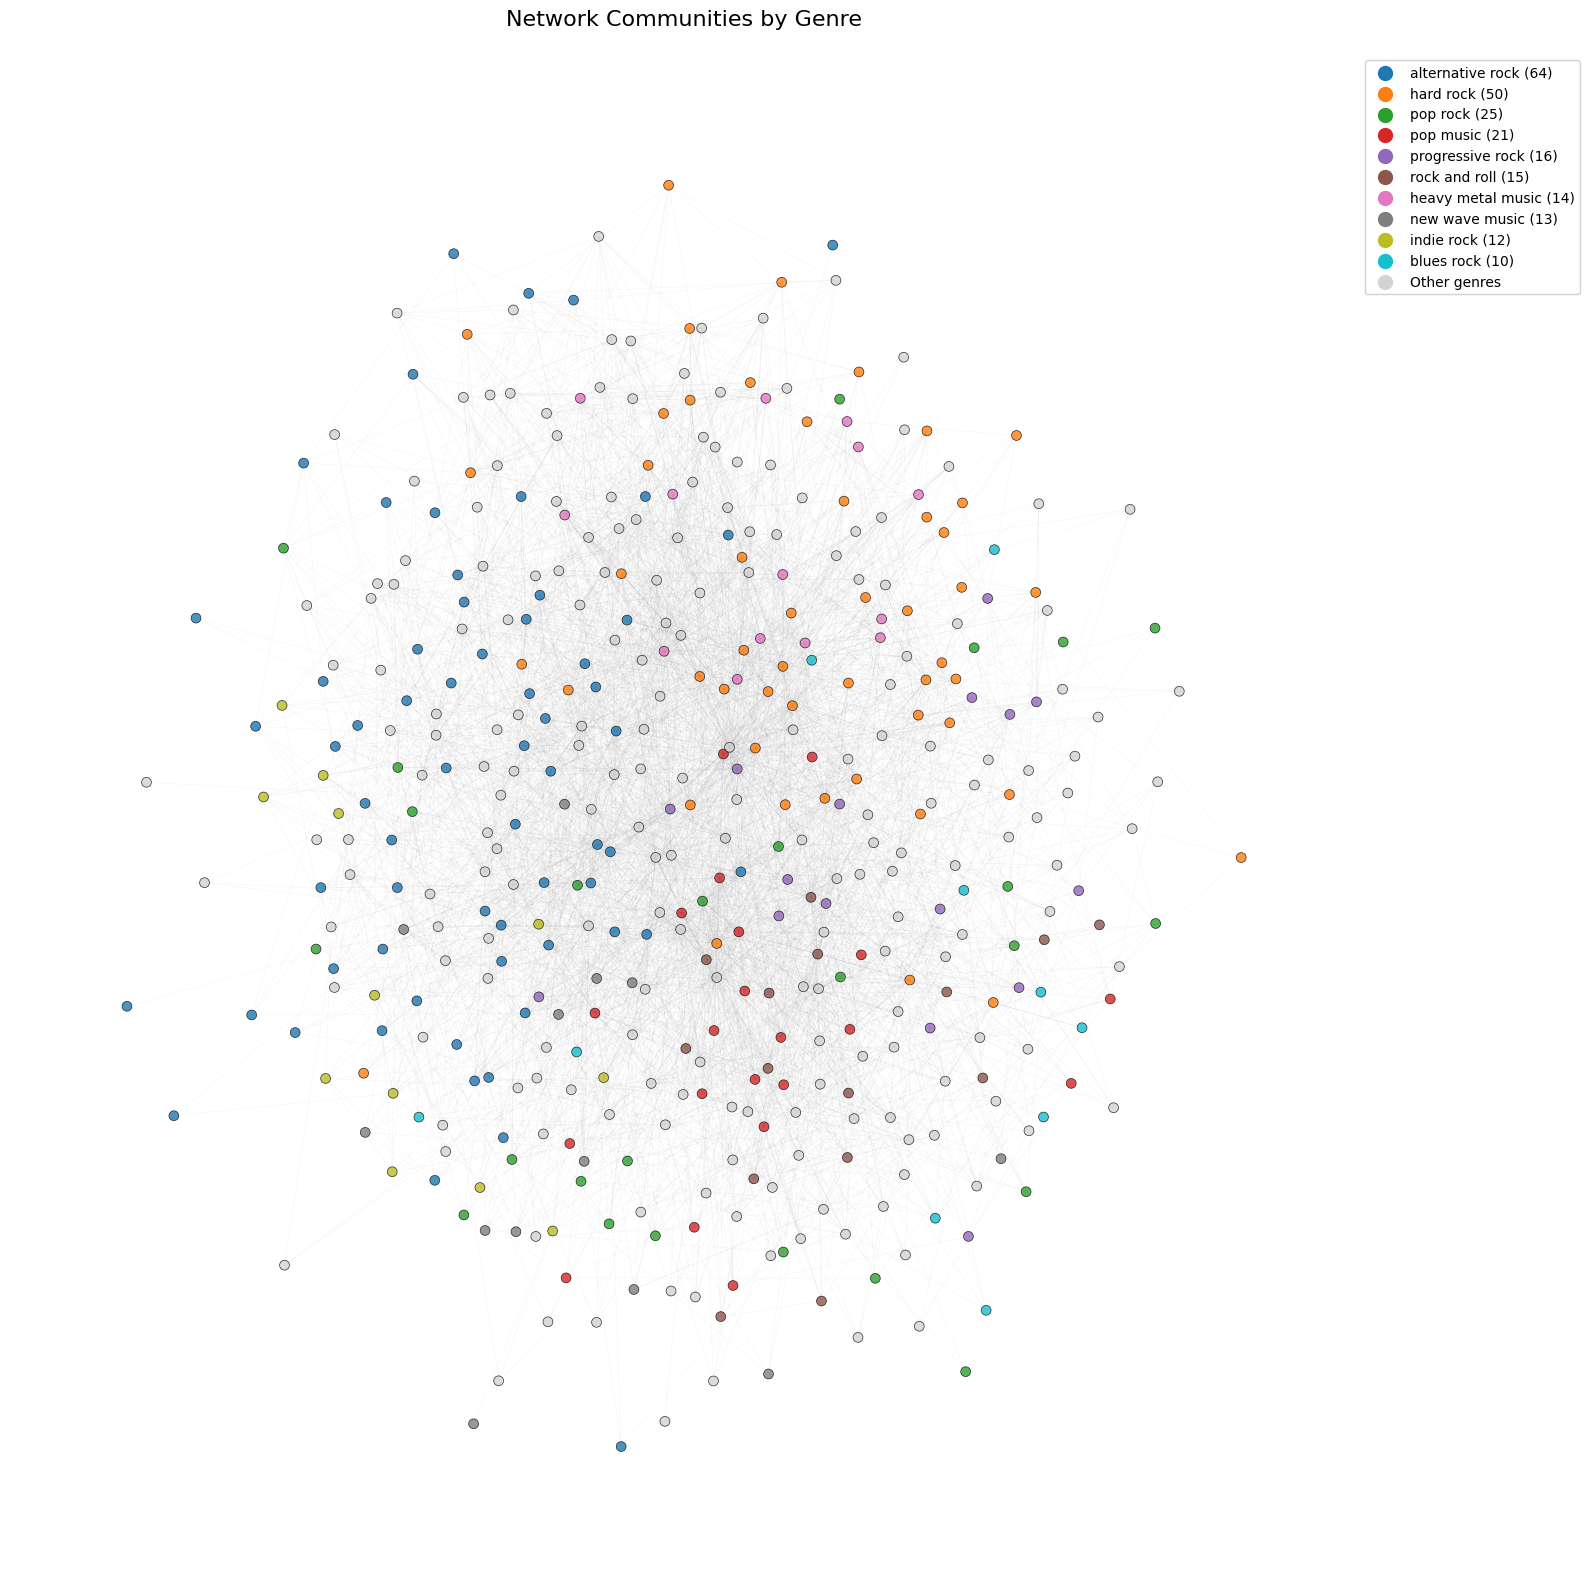

In [198]:
plt.figure(figsize=(16, 16))

# Create color map for top genres only (to reduce visual clutter)
top_genres = sorted(genre_to_nodes.items(), key=lambda x: len(x[1]), reverse=True)[:10]
top_genre_names = [g[0] for g in top_genres]

# Use distinct colors
colors = plt.cm.tab10(np.linspace(0, 1, 10))
genre_to_color = dict(zip(top_genre_names, colors))

# Assign colors - group small genres as "Other"
node_colors = []
for node in G_filtered.nodes():
    node_genre = G_filtered.nodes[node].get('genre', 'unknown')
    if node_genre in genre_to_color:
        node_colors.append(genre_to_color[node_genre])
    else:
        node_colors.append('lightgray')

# Use Kamada-Kawai layout for better community separation
# or try: pos = nx.spring_layout(G_filtered, k=1.5, iterations=100, seed=42)
pos = nx.kamada_kawai_layout(G_filtered)

# Draw edges first (so they're in background)
nx.draw_networkx_edges(G_filtered, pos, alpha=0.1, width=0.3, edge_color='gray')

# Draw nodes
nx.draw_networkx_nodes(G_filtered, pos, node_color=node_colors, 
                        node_size=50, alpha=0.8, linewidths=0.5, edgecolors='black')

# Create legend
legend_elements = []
for genre, nodes in top_genres:
    legend_elements.append(plt.scatter([], [], c=[genre_to_color[genre]], 
                                      s=100, label=f'{genre} ({len(nodes)})'))
legend_elements.append(plt.scatter([], [], c='lightgray', s=100, label='Other genres'))

plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), 
           fontsize=10, framealpha=0.9)
plt.title("Network Communities by Genre", fontsize=16, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

The plot more or less confirms what was suspected with the low modularity. There is no clear partition between the communities, with many edges going between genres. With 91 communities it is also clear that there are many smaller communities. 

### Conclusion

It can be concluded that there is very little evidence supporting the hypothesis, og bands within same subgenre being more linked than others. The analysis has shown a low modularity, that indicates a poor partition between genres, and further research like the D-matrix shows the majority of edges are between genres, not within the same genre. Lastly the plot showed no clear partition between the genres. Therefore, it can be concluded that there is no significant evidence suggesting artists within the same sub-genre are more linked than others.

## Part 3

### Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.

Term Frequency-Inverse Document Frequency is a measure that shows the importance of a word in relation to a document as a part of a collection. Meaning it is a variable that tracks how often a word is mentionend in the document, and then compares it with how infrequent it is mentioned in the whole collection. Words that are often mentionend in a document but very infrequent in the collection, have a high TF-IDF score and is therefore considered important. 

This could be useful in distinguishing how important a certain genre is for a specific artist compared to the collection of artists. A genre with high TF-IDF score would be mentioned often in the specific artists wiki page, but rarely mentioned in other wiki pages. It could help determine how distinct a certain genre is in relation to the artist. 

In [199]:
artist_genres = {}  # {artist_name: {genre: count}}
genre_document_frequency = defaultdict(int)  #

for node in G_rock.nodes():
    genres = G_rock.nodes[node].get('genres', {})
    if genres:  # Only include artists with genre data
        artist_genres[node] = genres
        # Count how many artists mention each genre
        for genre in genres.keys():
            genre_document_frequency[genre] += 1

total_artists = len(artist_genres)

idf = {}
for genre, doc_freq in genre_document_frequency.items():
    # IDF = log(total documents / documents containing term)
    idf[genre] = math.log(total_artists / doc_freq)

# Step 3: Calculate TF-IDF for each artist
tfidf_scores = {}

total_artists = len(artist_genres)

for artist, genres in artist_genres.items():
    tfidf_scores[artist] = {}
    
    # Calculate total genre mentions for normalization (TF)
    total_genre_mentions = sum(genres.values())
    
    if total_genre_mentions > 0:
        for genre, count in genres.items():
            # TF = (genre count in this artist's page) / (total genre mentions)
            tf = count / total_genre_mentions
            
            # TF-IDF = TF * IDF
            tfidf_scores[artist][genre] = tf * idf[genre]

def get_top_genres_for_artist(artist_name, tfidf_scores, top_n=5):
    """Get the top N genres by TF-IDF score for an artist."""
    if artist_name not in tfidf_scores:
        return []
    
    artist_scores = tfidf_scores[artist_name]
    sorted_genres = sorted(artist_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_genres[:top_n]

# Example usage:
artist = "Led Zeppelin"
top_genres = get_top_genres_for_artist(artist, tfidf_scores, top_n=5)
print(f"\nTop genres for {artist}:")
for genre, score in top_genres:
    print(f"  {genre}: {score:.4f}")

# Get most distinctive genres overall (highest average TF-IDF)
def get_most_distinctive_genres(tfidf_scores, top_n=10):
    """Find genres with highest average TF-IDF scores across artists."""
    genre_avg_scores = defaultdict(list)
    
    for artist, genres in tfidf_scores.items():
        for genre, score in genres.items():
            genre_avg_scores[genre].append(score)
    
    avg_scores = {genre: np.mean(scores) for genre, scores in genre_avg_scores.items()}
    sorted_genres = sorted(avg_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_genres[:top_n]

print("\nMost distinctive genres overall:")
for genre, avg_score in get_most_distinctive_genres(tfidf_scores):
    print(f"  {genre}: {avg_score:.4f}")


Top genres for Led Zeppelin:
  heavy metal: 1.0237
  hard rock: 0.3745
  heavy metal music: 0.2789
  folk rock: 0.1895
  class=nowraplinks: 0.1492

Most distinctive genres overall:
  jam rock: 6.1159
  garage punk: 3.6695
  western: 3.5064
  celtic punk: 3.3828
  hip-hop: 3.3117
  metal: 3.2932
  britpop: 3.2688
  british blues: 3.2251
  psychedelic soul: 2.9438
  melodic metalcore: 2.9283


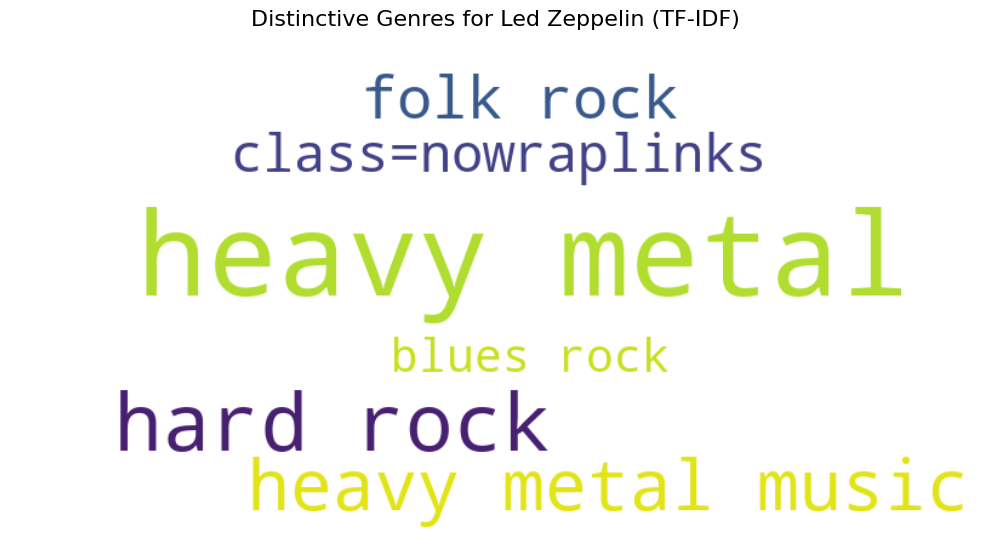

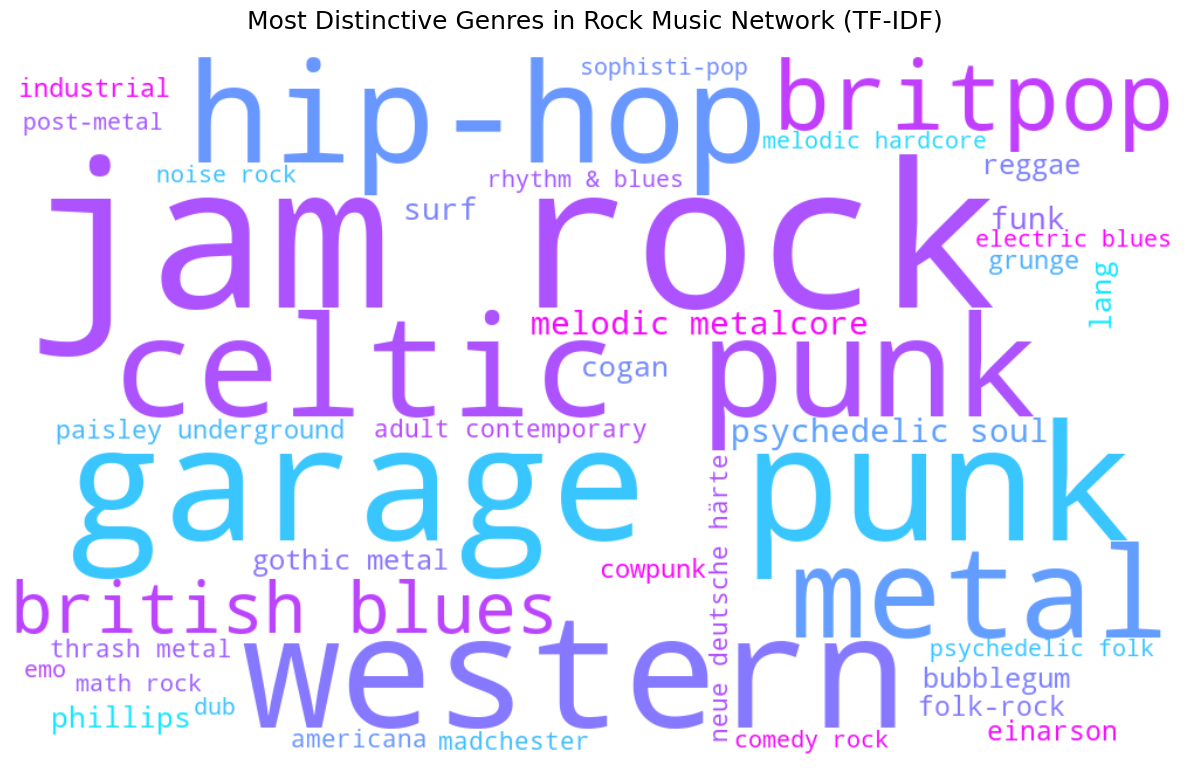

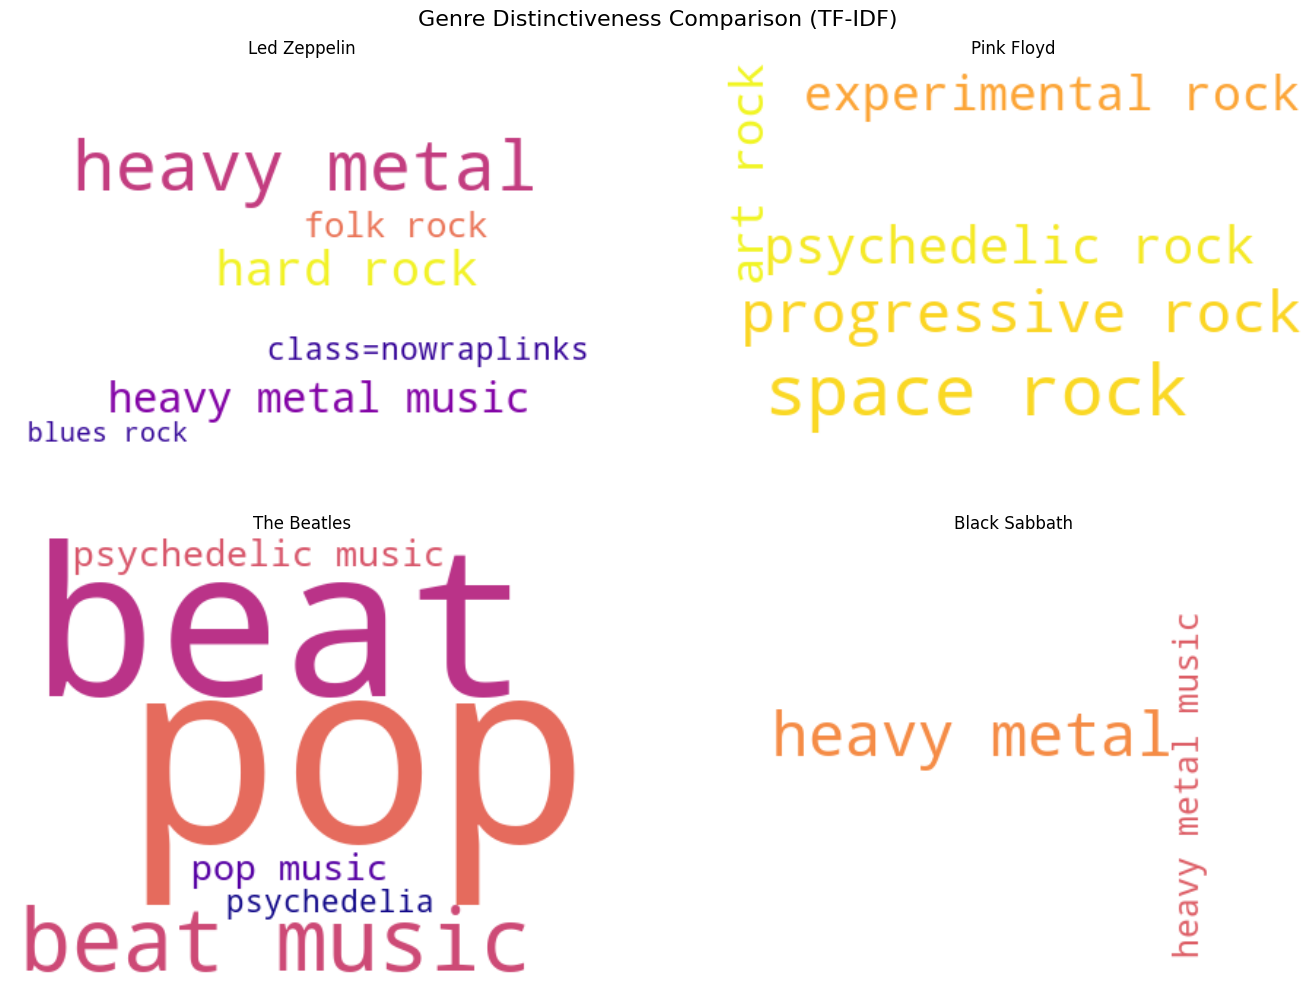

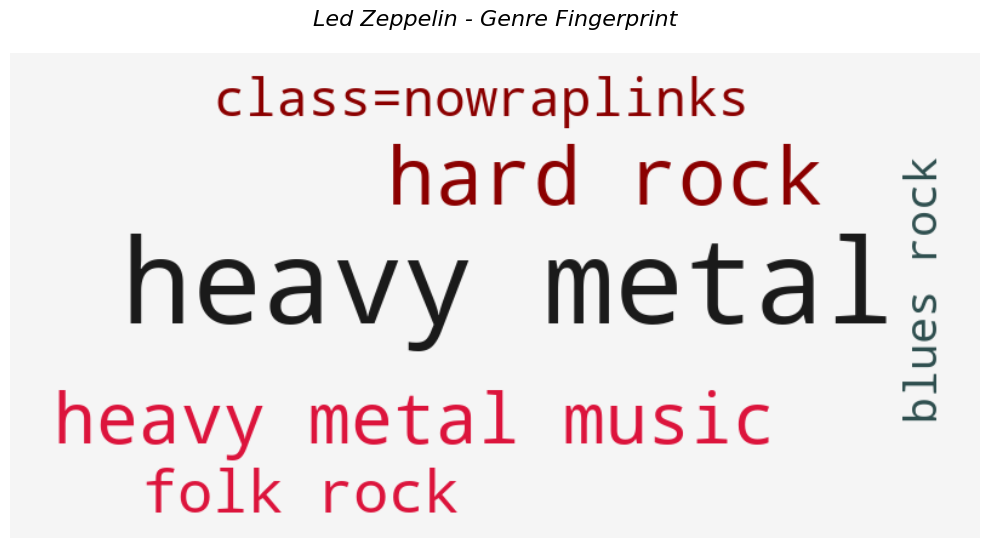

In [203]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# 1. Word cloud for a specific artist based on their TF-IDF scores
def create_artist_wordcloud(artist_name, tfidf_scores, figsize=(10, 6)):
    """Create a word cloud for a specific artist based on their TF-IDF scores."""
    
    if artist_name not in tfidf_scores:
        print(f"No data found for {artist_name}")
        return
    
    # Get the artist's genre scores
    genre_scores = tfidf_scores[artist_name]
    
    # WordCloud expects a dictionary of word: weight
    # Scale up the scores for better visibility (TF-IDF scores can be small)
    scaled_scores = {genre: score * 1000 for genre, score in genre_scores.items()}
    
    # Create the word cloud
    wordcloud = WordCloud(width=800, 
                          height=400,
                          background_color='white',
                          colormap='viridis',
                          relative_scaling=0.5,
                          min_font_size=10).generate_from_frequencies(scaled_scores)
    
    # Plot
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Distinctive Genres for {artist_name} (TF-IDF)', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    return wordcloud

# Example: Create word cloud for Led Zeppelin
create_artist_wordcloud("Led Zeppelin", tfidf_scores)

# 2. Word cloud for overall most distinctive genres
def create_overall_genres_wordcloud(tfidf_scores, top_n=50, figsize=(12, 8)):
    """Create a word cloud of the most distinctive genres overall."""
    
    # Calculate average TF-IDF for each genre across all artists
    genre_avg_scores = defaultdict(list)
    
    for artist, genres in tfidf_scores.items():
        for genre, score in genres.items():
            genre_avg_scores[genre].append(score)
    
    # Calculate mean scores
    avg_scores = {genre: np.mean(scores) for genre, scores in genre_avg_scores.items()}
    
    # Sort and get top N
    sorted_genres = sorted(avg_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    genre_weights = dict(sorted_genres)
    
    # Scale up for visibility
    scaled_weights = {genre: score * 1000 for genre, score in genre_weights.items()}
    
    # Create word cloud
    wordcloud = WordCloud(width=1000,
                          height=600,
                          background_color='white',
                          colormap='cool',
                          relative_scaling=0.5,
                          min_font_size=10).generate_from_frequencies(scaled_weights)
    
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Distinctive Genres in Rock Music Network (TF-IDF)', fontsize=18, pad=20)
    plt.tight_layout()
    plt.show()
    
    return wordcloud

# Create overall genres word cloud
overall_wc = create_overall_genres_wordcloud(tfidf_scores, top_n=40)

# 3. Comparative visualization - multiple artists
def create_comparison_wordclouds(artist_list, tfidf_scores, cols=2, figsize=(15, 10)):
    """Create a grid of word clouds for multiple artists for comparison."""
    
    rows = (len(artist_list) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Flatten axes array for easier iteration
    if rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()
    
    for idx, artist in enumerate(artist_list):
        if artist in tfidf_scores:
            genre_scores = tfidf_scores[artist]
            scaled_scores = {genre: score * 1000 for genre, score in genre_scores.items()}
            
            # Create word cloud with consistent settings
            wc = WordCloud(width=400,
                          height=300,
                          background_color='white',
                          colormap='plasma',
                          relative_scaling=0.5,
                          min_font_size=8).generate_from_frequencies(scaled_scores)
            
            axes[idx].imshow(wc, interpolation='bilinear')
            axes[idx].set_title(artist, fontsize=12)
            axes[idx].axis('off')
    
    # Hide any unused subplots
    for idx in range(len(artist_list), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Genre Distinctiveness Comparison (TF-IDF)', fontsize=16)
    plt.tight_layout()
    plt.show()

# Example: Compare multiple artists
artists_to_compare = ["Led Zeppelin", "Pink Floyd", "The Beatles", "Black Sabbath"]
create_comparison_wordclouds(artists_to_compare, tfidf_scores)

# 4. Interactive function to explore any artist
def interactive_artist_wordcloud():
    """Simple interactive function to create word clouds for any artist in the dataset."""
    
    # List available artists
    available_artists = list(tfidf_scores.keys())
    print(f"Found {len(available_artists)} artists with genre data.")
    print("\nSome examples:", available_artists[:10])
    
    while True:
        artist_input = input("\nEnter artist name (or 'quit' to exit): ").strip()
        
        if artist_input.lower() == 'quit':
            break
            
        if artist_input in tfidf_scores:
            create_artist_wordcloud(artist_input, tfidf_scores)
            
            # Show top genres for this artist
            top_genres = get_top_genres_for_artist(artist_input, tfidf_scores, top_n=5)
            print(f"\nTop 5 distinctive genres for {artist_input}:")
            for genre, score in top_genres:
                print(f"  {genre}: {score:.4f}")
        else:
            print(f"Artist '{artist_input}' not found in the dataset.")
            # Suggest similar names
            suggestions = [a for a in available_artists if artist_input.lower() in a.lower()][:5]
            if suggestions:
                print("Did you mean one of these?", suggestions)

# Uncomment to use the interactive function
# interactive_artist_wordcloud()

# 5. Bonus: Stylized word cloud with custom colors
def create_stylized_wordcloud(artist_name, tfidf_scores, figsize=(10, 6)):
    """Create a more stylized word cloud with custom colors."""
    
    if artist_name not in tfidf_scores:
        print(f"No data found for {artist_name}")
        return
    
    genre_scores = tfidf_scores[artist_name]
    scaled_scores = {genre: score * 1000 for genre, score in genre_scores.items()}
    
    # Custom color function for rock theme
    def rock_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        # Rock-themed colors: blacks, grays, reds
        return np.random.choice(['#1a1a1a', '#4a4a4a', '#8b0000', '#dc143c', '#2f4f4f'])
    
    wordcloud = WordCloud(width=800,
                          height=400,
                          background_color='#f5f5f5',
                          relative_scaling=0.5,
                          min_font_size=10,
                          max_words=50).generate_from_frequencies(scaled_scores)
    
    # Recolor with custom function
    wordcloud.recolor(color_func=rock_color_func)
    
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{artist_name} - Genre Fingerprint', fontsize=16, pad=20, style='italic')
    plt.tight_layout()
    plt.show()
    
    return wordcloud

# Example with stylized version
create_stylized_wordcloud("Led Zeppelin", tfidf_scores)

In [239]:
# Sort all artists into corresponding genres
import re


top = sorted(genre_to_nodes.items(), key=lambda x: len(x[1]), reverse=True)[:15]

freq_words_to_genre = {}
for genre, nodes in top:
    print(f"Processing genre: {genre} with {len(nodes)} nodes")
    collected_text = ""
    for node in nodes:
        #print(node)
        file_path = f"wiki_pages/{node.replace(' ', '_')}.txt"
        # Read the file
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()

        # First remove common wiki markup
        clean_text = text
        clean_text = re.sub(r'\[\[.*?\]\]', ' ', clean_text)  # Remove links
        clean_text = re.sub(r'\{\{.*?\}\}', ' ', clean_text)  # Remove templates
        clean_text = re.sub(r'<.*?>', ' ', clean_text)  # Remove HTML tags
        clean_text = re.sub(r'==.*?==', ' ', clean_text)  # Remove headers
        clean_text = re.sub(r'\|.*?\|', ' ', clean_text)  # Remove table markup
        collected_text += " " + clean_text
    
    #print(f"Collected text length for genre '{genre}': {len(collected_text)} characters")
    word_freq = {}
    regex_collected_text = re.findall(r'\b[a-zA-Z]{4,}\b', collected_text.lower())

    for idx, word in enumerate(set(regex_collected_text)):
        #Print progrss:
        #print(f"Progress: {idx+1}/{len(set(regex_collected_text))}", end='\r')
        for word2 in regex_collected_text:
            if word == word2:  # Ignore very short words
                word_freq[word] = word_freq.get(word, 0) + 1
    
    freq_words_to_genre[genre] = word_freq
    
    



Processing genre: alternative rock with 64 nodes
Processing genre: hard rock with 50 nodes
Processing genre: pop rock with 25 nodes
Processing genre: pop music with 21 nodes
Processing genre: progressive rock with 16 nodes
Processing genre: rock and roll with 15 nodes
Processing genre: heavy metal music with 14 nodes
Processing genre: new wave music with 13 nodes
Processing genre: indie rock with 12 nodes
Processing genre: blues rock with 10 nodes
Processing genre: folk rock with 10 nodes
Processing genre: post-grunge with 10 nodes
Processing genre: punk rock with 9 nodes
Processing genre: alternative metal with 9 nodes
Processing genre: soft rock with 9 nodes


In [258]:
with open("genre_frequent_words.json", 'w', encoding='utf-8') as f:
    json.dump(freq_words_to_genre, f, indent=2)

In [259]:
# Step 1: Calculate which genres contain each word (for IDF)
word_in_genres = defaultdict(set)
for genre, word_freq in freq_words_to_genre.items():
    for word in word_freq.keys():
        word_in_genres[word].add(genre)

# Step 2: Calculate IDF for each word
total_genres = len(freq_words_to_genre)
word_idf = {}


for word, genres_set in word_in_genres.items():
    # IDF = log(total number of genres / number of genres containing the word)
    idf = math.log(total_genres / len(genres_set))
    word_idf[word] = idf

# Step 3: Calculate TF-IDF for each word in each genre
genre_tfidf = {}

for genre, word_freq in freq_words_to_genre.items():
    # Calculate total words in this genre for TF normalization
    total_words = sum(word_freq.values())
    
    # Calculate TF-IDF for each word
    tfidf_scores = {}
    for word, count in word_freq.items():
        # TF = word count / total words in genre
        tf = count / total_words
        
        # TF-IDF = TF * IDF
        tfidf = tf * word_idf[word]
        tfidf_scores[word] = tfidf
    
    genre_tfidf[genre] = tfidf_scores

# Step 4: View results - top words for each genre
for genre, tfidf_scores in genre_tfidf.items():
    #print(f"\nTop 10 distinctive words for '{genre}':")
    top_words = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:10]
    #for word, score in top_words:
        #print(f"  {word}: {score:.6f}")

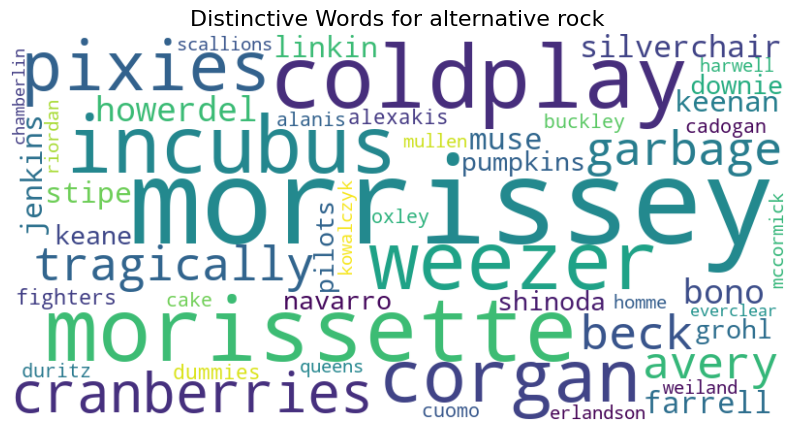

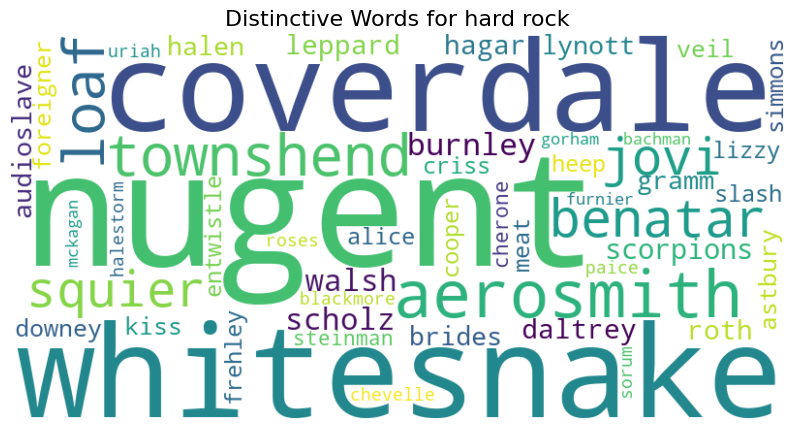

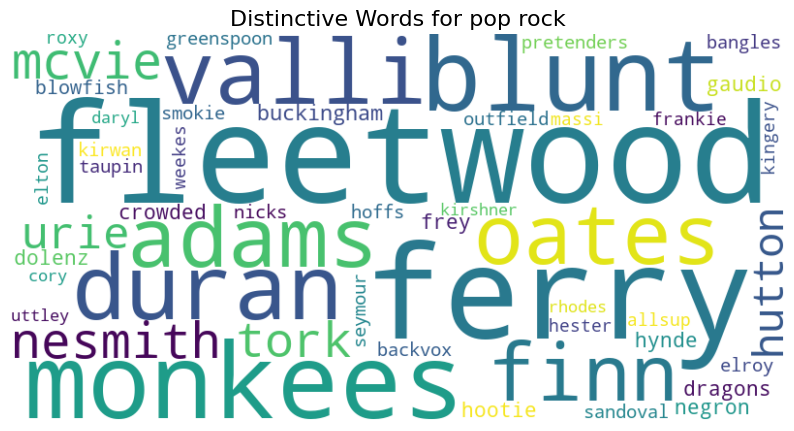

In [260]:
def create_genre_wordcloud(genre_name, genre_tfidf, figsize=(10, 6)):
    if genre_name not in genre_tfidf:
        print(f"Genre '{genre_name}' not found")
        return
    
    # Scale up the scores for visibility
    scores = genre_tfidf[genre_name]
    scaled_scores = {word: score * 100000 for word, score in scores.items()}
    
    wordcloud = WordCloud(width=800,
                          height=400,
                          background_color='white',
                          colormap='viridis',
                          max_words=50).generate_from_frequencies(scaled_scores)
    
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Distinctive Words for {genre_name}', fontsize=16)
    plt.show()

for genre_name in top_communities[:3]:
    create_genre_wordcloud(genre_name, genre_tfidf)

The above seen wordclouds are calculated from the TF-IDF scores based on words in the communities - meaning each distinct word has been tallied up over all text in the community. The size of the words in the wordcloud denotes how distinct this word is for the community.

And as one might expect, band names or names of prolific characters within the genre is very distinct to that given genre.